# Preparing Data

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import gurobipy as gp
from gurobipy import GRB
import math
from itertools import cycle

C:\Users\Cole\anaconda3\envs\generative_classifier\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def find_between(s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""

In [3]:
image_width, image_height = 14, 14 # 28, 28
window_size = 1
epsilon = 0.000000001
variable_type = GRB.BINARY # GRB.CONTINUOUS, GRB.INTEGER, GRB.BINARY

In [4]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([ToTensor(), transforms.Resize([image_width, image_height])])
)

In [5]:
batch_size = 30 # MUST BE EVENLY DIVISIBLE BY 10

# not sure what "...and so on" implies, but define this list however you like
target_classes = [i // (batch_size / 10) for i in range(batch_size)]

# create cyclic iterators of indices for each class in MNIST
indices = dict()
for label in torch.unique(training_data.targets).tolist():
    indices[label] = cycle(torch.nonzero(training_data.targets == label).flatten().tolist())

# define the order of indices in the new mnist subset based on target_classes
new_indices = []
for t in target_classes:
    new_indices.append(next(indices[t]))

# create a Subset of MNIST based on new_indices
mnist_modified = torch.utils.data.Subset(training_data, new_indices)
dataloader = torch.utils.data.DataLoader(mnist_modified, batch_size=batch_size, shuffle=False)

for idx, (x, y) in enumerate(dataloader):
    # training loop
    print(f'Batch {idx+1} labels: {y.tolist()}')

Batch 1 labels: [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9]


tensor([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7,
        8, 8, 8, 9, 9, 9])
torch.Size([14, 14])


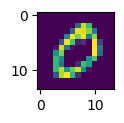

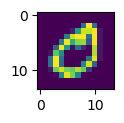

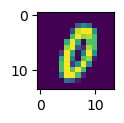

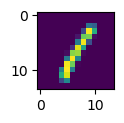

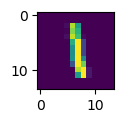

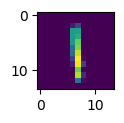

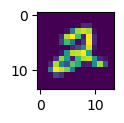

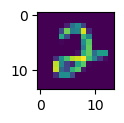

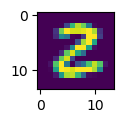

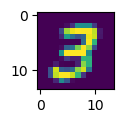

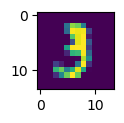

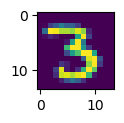

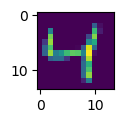

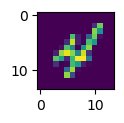

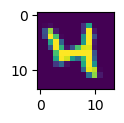

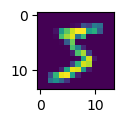

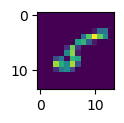

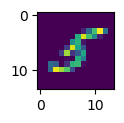

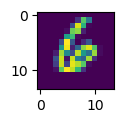

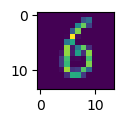

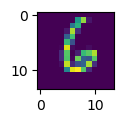

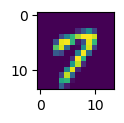

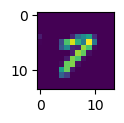

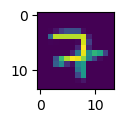

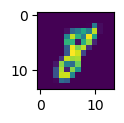

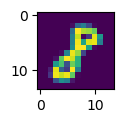

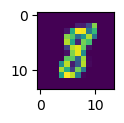

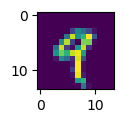

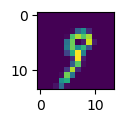

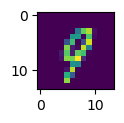

In [6]:
dataset = next(enumerate(dataloader))[1]
print(dataset[1])
print(dataset[0][1, 0].shape)
for img in range(len(dataset[1])):
    plt.figure(figsize=[1, 1])
    plt.imshow(dataset[0][img, 0])
    plt.show()

# Constraints:
- pixels don't criss-cross
- all source pixels used
- all dest pixels mapped

# Objective:
minimize mapped L2 distance

In [7]:
m = gp.Model("image_similarity")
m.Params.LogToConsole = 0
m.setParam("Method", 3)

# initialize pixel shift values
image_shift_values = m.addVars(image_width, image_height, (2*window_size+1), (2*window_size+1), vtype=variable_type, lb=0, ub=1, name="shifts")

# add constraints that if a pixel shift is outside image, it must be 0
for x_pixel in range(image_width):
    for y_pixel in range(image_height):
        for x_shift in range(2*window_size+1):
            for y_shift in range(2*window_size+1):
                if x_pixel + (x_shift - window_size) < 0 or x_pixel + (x_shift - window_size) > image_width-1 or y_pixel + (y_shift - window_size) < 0 or y_pixel + (y_shift - window_size) > image_height-1:
                    m.addConstr(image_shift_values[x_pixel, y_pixel, x_shift, y_shift] == 0)


# constraints that all source pixels must shift in at least 1 direction
for x_pixel in range(image_width):
    for y_pixel in range(image_height):
        m.addConstr(gp.quicksum(image_shift_values[x_pixel, y_pixel, x_shift, y_shift] for x_shift in range(2*window_size+1) for y_shift in range(2*window_size+1)) >= 1)

# constraints that all dest pixels must be mapped to
for x_pixel in range(image_width):
    for y_pixel in range(image_height):
        m.addConstr(gp.quicksum(image_shift_values[x_pixel - (x_shift - window_size), y_pixel - (y_shift - window_size), x_shift, y_shift] \
                                for x_shift in range(2*window_size+1) for y_shift in range(2*window_size+1) \
                                if x_pixel - (x_shift - window_size) >= 0 and x_pixel - (x_shift - window_size) < image_width and y_pixel - (y_shift - window_size) >= 0 and y_pixel - (y_shift - window_size) < image_height) \
                    >= 1)

def add_left_constraint(x_pixel, y_pixel, x_shift, y_shift):
    if x_shift != 2*window_size and x_shift != 2*window_size-1: # left pixel can't be more right than curr pixel
        max1 = m.addVar(name=f"amax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        max2 = m.addVar(name=f"amax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        max3 = m.addVar(name=f"amax3_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        m.addConstr(max1 == gp.max_(image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for xShifts in range(x_shift+1) for yShifts in range(2*window_size+1)))
        m.addConstr(max2 == gp.max_(image_shift_values[x_pixel-1, y_pixel, xShifts, yShifts] for xShifts in range(x_shift+2, 2*window_size+1) for yShifts in range(2*window_size+1)))
        # m.addConstr(max1 + max2 <= 1)
        m.addConstr(max3 == gp.max_(max1, max2))
        m.addConstr(max1 + max2 <= max3)
        
def add_down_constraint(x_pixel, y_pixel, x_shift, y_shift):
    if y_shift != 2*window_size and y_shift != 2*window_size-1: # left pixel can't be more right than curr pixel
        max1 = m.addVar(name=f"bmax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        max2 = m.addVar(name=f"bmax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        max3 = m.addVar(name=f"bmax3_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        m.addConstr(max1 == gp.max_(image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for xShifts in range(2*window_size+1) for yShifts in range(y_shift+1)))
        m.addConstr(max2 == gp.max_(image_shift_values[x_pixel, y_pixel-1, xShifts, yShifts] for xShifts in range(2*window_size+1) for yShifts in range(y_shift+2, 2*window_size+1)))
        # m.addConstr(max1 + max2 <= 1)
        m.addConstr(max3 == gp.max_(max1, max2))
        m.addConstr(max1 + max2 <= max3)

def add_down_left_constraint(x_pixel, y_pixel, x_shift, y_shift):
    if x_shift != 2*window_size and x_shift != 2*window_size-1: # left pixel can't be more right than curr pixel
        max1 = m.addVar(name=f"cmax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        max2 = m.addVar(name=f"cmax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        max3 = m.addVar(name=f"cmax3_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        m.addConstr(max1 == gp.max_(image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for xShifts in range(x_shift+1) for yShifts in range(2*window_size+1)))
        m.addConstr(max2 == gp.max_(image_shift_values[x_pixel-1, y_pixel-1, xShifts, yShifts] for xShifts in range(x_shift+2, 2*window_size+1) for yShifts in range(2*window_size+1)))
        # m.addConstr(max1 + max2 <= 1)
        m.addConstr(max3 == gp.max_(max1, max2))
        m.addConstr(max1 + max2 <= max3)
    if y_shift != 2*window_size and y_shift != 2*window_size-1: # left pixel can't be more right than curr pixel
        max1 = m.addVar(name=f"dmax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        max2 = m.addVar(name=f"dmax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        max3 = m.addVar(name=f"dmax3_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        m.addConstr(max1 == gp.max_(image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for xShifts in range(2*window_size+1) for yShifts in range(y_shift+1)))
        m.addConstr(max2 == gp.max_(image_shift_values[x_pixel-1, y_pixel-1, xShifts, yShifts] for xShifts in range(2*window_size+1) for yShifts in range(y_shift+2, 2*window_size+1)))
        # m.addConstr(max1 + max2 <= 1)
        m.addConstr(max3 == gp.max_(max1, max2))
        m.addConstr(max1 + max2 <= max3)
        
def add_upleft_constraint(x_pixel, y_pixel, x_shift, y_shift):
    if x_shift != 2*window_size and x_shift != 2*window_size-1: # left pixel can't be more right than curr pixel
        max1 = m.addVar(name=f"emax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        max2 = m.addVar(name=f"emax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        max3 = m.addVar(name=f"emax3_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        m.addConstr(max1 == gp.max_(image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for xShifts in range(x_shift+1) for yShifts in range(2*window_size+1)))
        m.addConstr(max2 == gp.max_(image_shift_values[x_pixel-1, y_pixel+1, xShifts, yShifts] for xShifts in range(x_shift+2, 2*window_size+1) for yShifts in range(2*window_size+1)))
        # m.addConstr(max1 + max2 <= 1)
        m.addConstr(max3 == gp.max_(max1, max2))
        m.addConstr(max1 + max2 <= max3)
    if y_shift != 0 and y_shift != 1: # left pixel can't be more right than curr pixel
        max1 = m.addVar(name=f"fmax1_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        max2 = m.addVar(name=f"fmax2_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        max3 = m.addVar(name=f"fmax3_{x_pixel}_{y_pixel}_{x_shift}_{y_shift}", vtype=variable_type)
        m.addConstr(max1 == gp.max_(image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for xShifts in range(2*window_size+1) for yShifts in range(y_shift, 2*window_size+1)))
        m.addConstr(max2 == gp.max_(image_shift_values[x_pixel-1, y_pixel+1, xShifts, yShifts] for xShifts in range(2*window_size+1) for yShifts in range(y_shift-1)))
        # m.addConstr(max1 + max2 <= 1)
        m.addConstr(max3 == gp.max_(max1, max2))
        m.addConstr(max1 + max2 <= max3)
        
        
# def add_blob_consistency_constraint(x_pixel, y_pixel, x_shift, y_shift):
#     m.addConstr(image_shift_values[x_pixel, y_pixel, x_shift, y_shift] <= gp.quicksum(image_shift_values[x_pixel, y_pixel, xShifts, yShifts] for yShifts in range(max(0, y_shift-1), min(y_shift+2, 2*window_size+1)) for xShifts in range(max(0, x_shift-1), min(x_shift+2, 2*window_size+1)) if xShifts != x_shift and yShifts != y_shift))
        
        
# add constraints that pixel shifts must be consistent
for x_pixel in range(image_width):
    # print(x_pixel)
    for y_pixel in range(image_height):
        for x_shift in range(2*window_size+1):
            for y_shift in range(2*window_size+1):
#                 add_blob_consistency_constraint(x_pixel, y_pixel, x_shift, y_shift)
                if y_pixel == 0 and x_pixel == 0:
                    continue
                elif y_pixel == 0:
                    add_left_constraint(x_pixel, y_pixel, x_shift, y_shift)
                elif x_pixel == 0:
                    add_down_constraint(x_pixel, y_pixel, x_shift, y_shift)
                else:
                    add_left_constraint(x_pixel, y_pixel, x_shift, y_shift)
                    add_down_constraint(x_pixel, y_pixel, x_shift, y_shift)
                    add_down_left_constraint(x_pixel, y_pixel, x_shift, y_shift)
                if y_pixel != image_height-1 and x_pixel != 0:
                    add_upleft_constraint(x_pixel, y_pixel, x_shift, y_shift)
                    
def initialize_model_values():
    for x_pixel in range(image_width):
        for y_pixel in range(image_height):
            for x_shift in range(2*window_size+1):
                for y_shift in range(2*window_size+1):
                    if x_shift == window_size and y_shift == window_size:
                        image_shift_values[x_pixel, y_pixel, x_shift, y_shift].start = 1
                    else:
                        image_shift_values[x_pixel, y_pixel, x_shift, y_shift].start = 0
                        
initialize_model_values()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-13


In [8]:
def get_similarity(img1, img2, image_width, image_height, window_size, verbose=False):

    # set objective function
    m.setObjective(gp.quicksum(((img1[x_pixel, y_pixel] - img2[x_pixel + (x_shift - window_size), y_pixel + (y_shift - window_size)]).item() ** 2) * image_shift_values[x_pixel, y_pixel, x_shift, y_shift] for x_pixel in range(image_width) for y_pixel in range(image_height) for x_shift in range(2*window_size+1) for y_shift in range(2*window_size+1) if x_pixel + (x_shift - window_size) >= 0 and x_pixel + (x_shift - window_size) <= image_width-1 and y_pixel + (y_shift - window_size) >= 0 and y_pixel + (y_shift - window_size) <= image_height-1)\
                   + (epsilon*gp.quicksum(image_shift_values)), GRB.MINIMIZE)
    m.optimize() 
    optimal_value = m.objVal
    
    return optimal_value

In [9]:
def get_similarity_score(image1, image2, image_width, image_height, window_size, verbose=False):
    initialize_model_values()
    val1 = get_similarity(image1, image2, image_width, image_height, window_size, verbose)
    initialize_model_values()
    val2 = get_similarity(image2, image1, image_width, image_height, window_size, verbose)
#     val2 = 0
    print([val1, val2])
    return max(val1, val2)

In [10]:
def generate_mapped_img(source_img):
    
    generated_img = torch.zeros(source_img.shape)
    
    shift_vals = m.getVars()
    
    for val in shift_vals:
        if val.X == 1:
            index = find_between(val.VarName, "[", "]").split(",")
            if "shifts" not in val.VarName:
                continue
            if source_img[int(index[0]), int(index[1])] > 0:
                generated_img[int(index[0]) + int(index[2])-window_size, int(index[1]) + int(index[3])-window_size] = max(source_img[int(index[0]), int(index[1])], \
                                                                                                                         generated_img[int(index[0]) + int(index[2])-window_size, int(index[1]) + int(index[3])-window_size])
    plt.imshow(generated_img)
    plt.show()

0


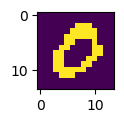

[2.0999999999999995e-07, 2.0999999999999995e-07]
2.0999999999999995e-07
[1.000000217000001, 1.000000218000001]
1.000000218000001
[21.000000213000007, 23.000000211000014]
23.000000211000014
[28.000000206000013, 26.000000209000014]
28.000000206000013
[29.000000210000014, 27.000000209000014]
29.000000210000014
[4.000000220000003, 5.000000218000005]
5.000000218000005
[7.0000002170000055, 7.000000216000006]
7.0000002170000055
[12.000000211000007, 9.000000215000007]
12.000000211000007
[7.000000213000005, 6.000000216000006]
7.000000213000005
[13.000000214000007, 13.000000218000011]
13.000000218000011
[17.00000022200001, 16.00000022300001]
17.00000022200001
[26.000000211000017, 25.000000217000014]
26.000000211000017
[12.00000021700001, 12.000000217000009]
12.00000021700001
[23.000000216000014, 23.999999895104427]
23.999999895104427
[13.000000214000007, 14.00000021400001]
14.00000021400001
[16.00000021700001, 16.00000021900001]
16.00000021900001
[10.00000021900001, 10.000000222000008]
10.000000

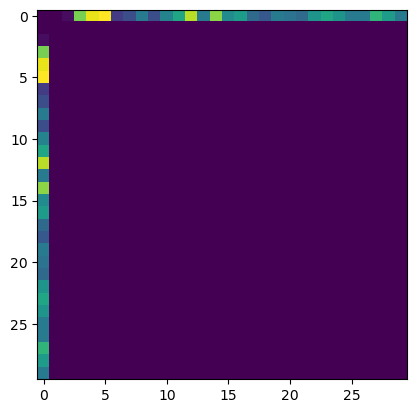

1


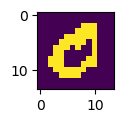

[4.000000214000003, 4.000000218000002]
4.000000218000002
[21.00000021400001, 22.00000021600001]
22.00000021600001
[32.000000207000014, 29.000000212000018]
32.000000207000014
[31.000000210000014, 29.000000210000014]
31.000000210000014
[4.000000221000005, 4.000000221000003]
4.000000221000005
[13.000000219000011, 10.000000220000011]
13.000000219000011
[6.0000002190000075, 6.000000218000007]
6.0000002190000075
[7.0000002170000055, 7.000000215000004]
7.0000002170000055
[13.00000021700001, 13.00000021700001]
13.00000021700001
[19.000000220000015, 18.000000223000015]
19.000000220000015
[26.000000217000018, 25.000000215000014]
26.000000217000018
[9.000000224000008, 10.000000224000011]
10.000000224000011
[18.000000221000015, 18.00000022500001]
18.00000022500001
[12.000000219000007, 13.00000022000001]
13.00000022000001
[16.00000022100001, 16.00000022100001]
16.00000022100001
[11.000000219000006, 11.000000222000004]
11.000000222000004
[11.00000022100001, 10.000000220000011]
11.00000022100001
[13.

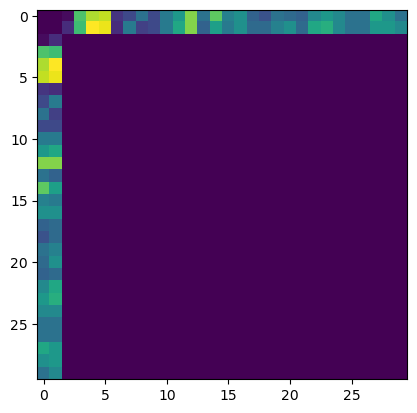

2


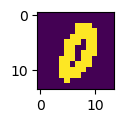

[13.000000215000009, 13.000000215000007]
13.000000215000009
[18.000000209000014, 18.000000210000014]
18.000000210000014
[23.000000210000014, 22.000000210000014]
23.000000210000014
[3.000000220000002, 3.0000002170000015]
3.000000220000002
[5.000000215000006, 6.000000214000006]
6.000000214000006
[8.000000212000005, 6.000000213000006]
8.000000212000005
[1.0000002110000012, 1.0000002120000004]
1.0000002120000004
[8.000000214000007, 8.000000214000009]
8.000000214000009
[16.000000219000015, 12.000000227000012]
16.000000219000015
[26.000000215000018, 24.000000215000014]
26.000000215000018
[6.000000218000007, 7.000000217000007]
7.000000217000007
[19.00000022300001, 19.000000219000015]
19.00000022300001
[11.00000021400001, 9.000000220000008]
11.00000021400001
[15.000000219000011, 15.00000021700001]
15.000000219000011
[9.000000221000008, 9.000000220000006]
9.000000221000008
[5.000000216000007, 4.0000002150000045]
5.000000216000007
[6.000000216000007, 6.000000217000009]
6.000000217000009
[9.00000

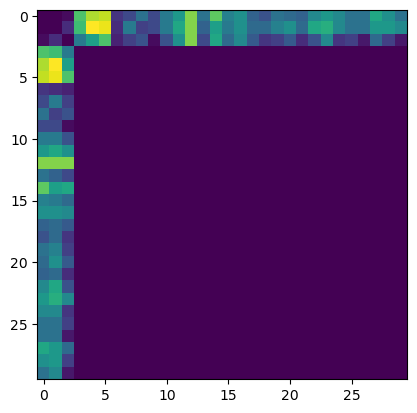

3


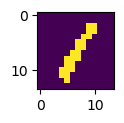

[16.000000208000014, 16.00000020800001]
16.000000208000014
[14.00000020600001, 14.000000205000008]
14.00000020600001
[15.00000021000001, 15.00000021100001]
15.00000021100001
[14.000000213000014, 14.000000213000016]
14.000000213000016
[19.00000021100001, 18.000000212000007]
19.00000021100001
[13.000000217000009, 12.00000022100001]
13.000000217000009
[13.000000211000012, 11.00000021400001]
13.000000211000012
[27.000000209000017, 26.000000210000017]
27.000000209000017
[27.000000210000014, 26.000000210000007]
27.000000210000014
[6.000000215000005, 6.000000212000005]
6.000000215000005
[24.000000210000014, 23.000000212000014]
24.000000210000014
[12.00000021600001, 12.000000215000009]
12.00000021600001
[4.000000207000006, 4.000000208000005]
4.000000208000005
[6.000000210000003, 6.000000209000002]
6.000000210000003
[16.000000210000007, 15.000000214000007]
16.000000210000007
[12.000000207000006, 11.00000021000001]
12.000000207000006
[20.000000206000013, 20.000000208000017]
20.000000208000017
[9

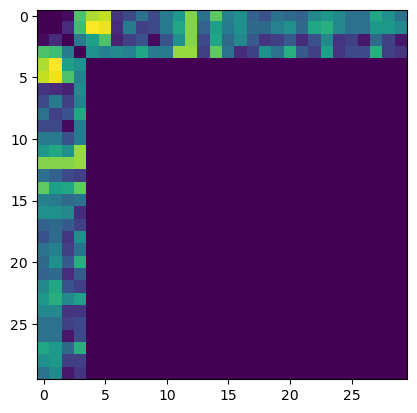

4


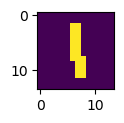

[2.0299999999999998e-07, 2.0299999999999998e-07]
2.0299999999999998e-07
[16.000000208000007, 18.000000207000006]
18.000000207000006
[19.00000020800001, 21.000000209000014]
21.000000209000014
[26.000000210000014, 29.000000209000014]
29.000000209000014
[16.000000213000014, 19.000000213000007]
19.000000213000007
[5.000000209000003, 6.000000208000003]
6.000000208000003
[14.000000215000012, 16.00000021400001]
16.00000021400001
[27.000000206000017, 26.000000208000014]
27.000000206000017
[15.000000209000014, 17.00000020800001]
17.00000020800001
[27.000000213000018, 28.000000208000014]
28.000000208000014
[13.00000020800001, 14.00000020600001]
14.00000020600001
[18.000000207000014, 19.00000020600001]
19.00000020600001
[16.000000203000013, 16.00000020200001]
16.000000203000013
[13.000000208000008, 14.000000211000007]
14.000000211000007
[5.000000208000003, 8.000000209000007]
8.000000209000007
[9.000000205000006, 10.000000210000007]
10.000000210000007
[19.000000205000013, 21.000000207000014]
21.00

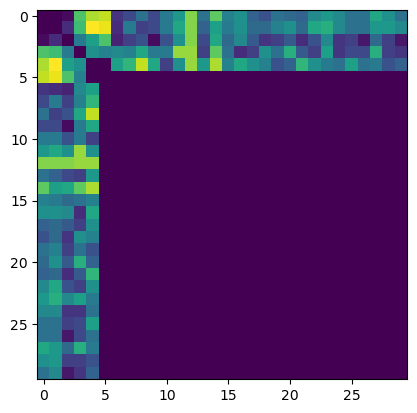

5


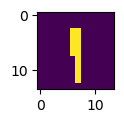

[18.00000020800001, 20.00000020700001]
20.00000020700001
[23.00000020900001, 24.00000020900001]
24.00000020900001
[27.000000214000014, 30.000000212000018]
30.000000212000018
[20.000000216000018, 23.000000213000014]
23.000000213000014
[7.000000212000004, 8.000000212000005]
8.000000212000005
[17.00000020900001, 19.00000020900001]
19.00000020900001
[29.000000203000017, 29.000000203000017]
29.000000203000017
[14.000000208000012, 16.000000208000014]
16.000000208000014
[30.000000209000017, 31.000000209000017]
31.000000209000017
[15.000000207000008, 17.00000020400001]
17.00000020400001
[15.00000020400001, 16.00000020600001]
16.00000020600001
[13.000000204000013, 13.00000020300001]
13.000000204000013
[15.00000021100001, 17.000000208000014]
17.000000208000014
[7.000000203000005, 9.000000204000004]
9.000000204000004
[12.00000020400001, 14.00000020600001]
14.00000020600001
[16.00000020700001, 18.00000020600001]
18.00000020600001
[11.000000205000006, 13.000000206000008]
13.000000206000008
[12.0000

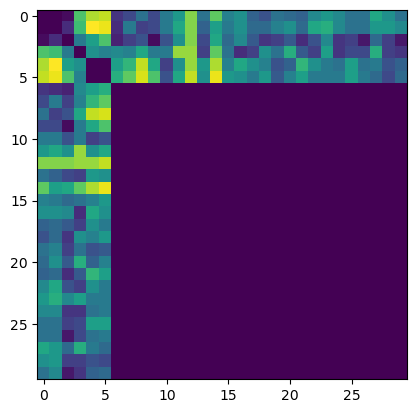

6


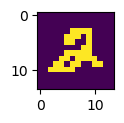

[3.000000209000003, 3.000000211000002]
3.000000211000002
[2.0000002220000006, 2.000000221000001]
2.0000002220000006
[4.000000219000002, 3.000000218000001]
4.000000219000002
[4.000000218000005, 4.0000002170000055]
4.000000218000005
[15.00000021700001, 14.000000218000011]
15.00000021700001
[25.000000210000014, 25.000000210000014]
25.000000210000014
[6.000000215000004, 6.000000213000006]
6.000000215000004
[17.00000021100001, 18.00000021000001]
18.00000021000001
[9.000000218000007, 10.000000216000005]
10.000000216000005
[14.000000211000014, 14.00000020900001]
14.000000211000014
[6.000000211000006, 5.000000213000004]
6.000000211000006
[5.000000210000006, 5.000000211000005]
5.000000211000005
[6.0000002130000025, 6.000000215000004]
6.000000215000004
[8.000000214000009, 9.000000216000009]
9.000000216000009
[10.000000211000005, 11.000000210000005]
11.000000210000005
[6.000000215000004, 6.000000214000003]
6.000000215000004
[6.000000214000004, 6.000000213000007]
6.000000214000004
[7.0000002120000

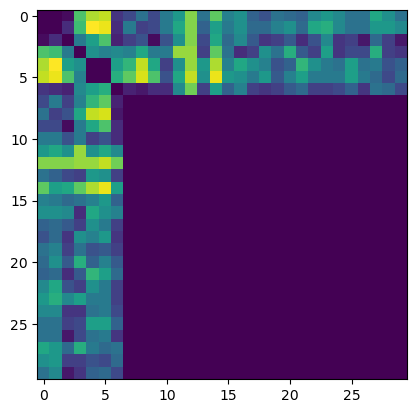

7


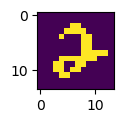

[8.000000218000007, 8.000000214000005]
8.000000218000007
[5.000000219000005, 4.000000218000002]
5.000000219000005
[7.000000212000006, 7.000000211000007]
7.000000212000006
[13.000000217000009, 13.00000021800001]
13.00000021800001
[26.000000211000017, 25.000000212000014]
26.000000211000017
[13.000000215000012, 13.000000213000012]
13.000000215000012
[17.000000215000018, 17.00000021500001]
17.000000215000018
[13.000000214000012, 14.000000214000009]
14.000000214000009
[18.00000021000001, 19.000000208000017]
19.000000208000017
[14.000000214000012, 15.00000021300001]
15.00000021300001
[7.000000210000008, 6.000000214000006]
7.000000210000008
[9.000000215000007, 10.00000021600001]
10.00000021600001
[10.000000210000008, 10.000000211000009]
10.000000211000009
[14.000000216000013, 14.000000213000009]
14.000000216000013
[11.000000212000009, 12.00000020700001]
12.00000020700001
[5.000000212000006, 5.000000212000007]
5.000000212000007
[8.000000217000007, 9.000000215000009]
9.000000215000009
[12.00000

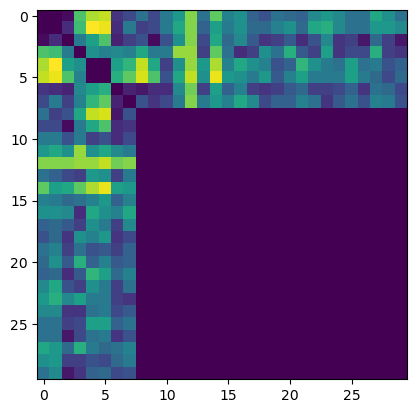

8


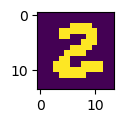

[3.0000002160000014, 2.000000215000001]
3.0000002160000014
[10.000000217000007, 10.000000217000009]
10.000000217000009
[10.000000219000011, 8.000000221000008]
10.000000219000011
[27.000000213000018, 26.000000213000018]
27.000000213000018
[16.00000021500001, 16.000000219000015]
16.000000219000015
[15.00000022000001, 16.000000216000014]
16.000000216000014
[9.000000219000007, 8.000000220000006]
9.000000219000007
[23.000000213000014, 23.000000212000018]
23.000000213000014
[17.00000021600001, 16.000000217000007]
17.00000021600001
[10.000000219000007, 11.000000220000008]
11.000000220000008
[9.00000022300001, 9.000000221000008]
9.00000022300001
[13.000000220000011, 14.000000217000013]
14.000000217000013
[17.00000021600001, 18.00000021500001]
18.00000021500001
[19.999999963700013, 20.000000213000014]
20.000000213000014
[18.00000021800001, 19.000000217000014]
19.000000217000014
[9.000000215000005, 8.000000216000004]
9.000000215000005
[12.000000211000009, 11.000000212000007]
12.000000211000009
[

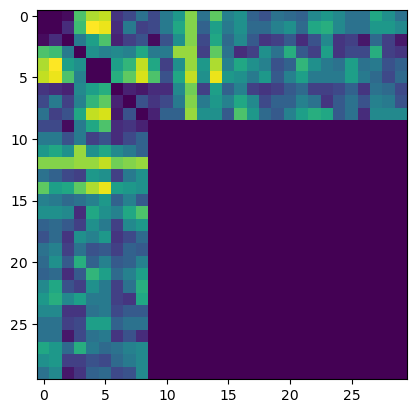

9


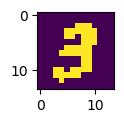

[3.0000002120000047, 3.0000002150000045]
3.0000002150000045
[6.0000002200000075, 7.0000002190000075]
7.0000002190000075
[24.000000213000018, 24.000000213000018]
24.000000213000018
[10.000000218000011, 9.00000021800001]
10.000000218000011
[16.000000220000015, 18.000000218000014]
18.000000218000014
[3.0000002170000024, 4.000000213000005]
4.000000213000005
[19.000000216000014, 19.00000021600001]
19.000000216000014
[8.000000220000008, 9.000000220000006]
9.000000220000006
[6.000000215000007, 6.0000002160000045]
6.0000002160000045
[8.000000214000007, 9.000000213000007]
9.000000213000007
[14.000000216000014, 14.000000215000012]
14.000000216000014
[4.000000217000004, 5.000000214000004]
5.000000214000004
[10.000000216000013, 11.00000021600001]
11.00000021600001
[15.000000214000014, 17.000000217000014]
17.000000217000014
[7.000000214000005, 8.000000210000005]
8.000000210000005
[7.000000216000004, 6.000000213000004]
7.000000216000004
[1.0000002140000008, 2.1699999999999994e-07]
1.0000002140000008

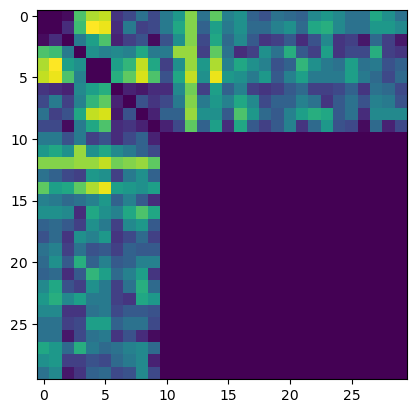

10


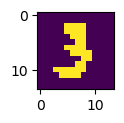

[4.000000214000005, 4.000000214000005]
4.000000214000005
[33.00000020900002, 33.00000020900002]
33.00000020900002
[16.000000211000014, 16.000000215000014]
16.000000215000014
[24.000000216000014, 24.000000216000014]
24.000000216000014
[4.000000213000005, 4.000000213000005]
4.000000213000005
[17.000000213000014, 17.00000021200001]
17.000000213000014
[9.000000214000012, 10.000000214000012]
10.000000214000012
[2.000000219000002, 1.000000220000001]
2.000000219000002
[4.0000002150000045, 6.000000213000006]
6.000000213000006
[8.000000211000009, 6.000000216000004]
8.000000211000009
[10.000000213000009, 11.00000021300001]
11.00000021300001
[9.00000021300001, 10.000000212000009]
10.000000212000009
[13.000000211000014, 13.00000021000001]
13.000000211000014
[6.000000213000008, 8.000000212000007]
8.000000212000007
[8.000000217000009, 10.000000214000007]
10.000000214000007
[3.000000212000005, 4.000000211000003]
4.000000211000003
[12.000000214000009, 11.000000217000006]
12.000000214000009
[4.00000021

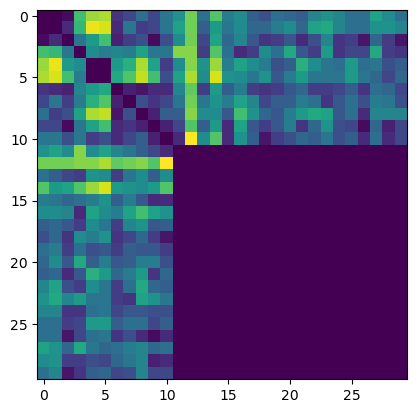

11


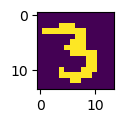

[28.000000214000018, 29.000000211000017]
29.000000211000017
[25.000000214000018, 26.000000215000014]
26.000000215000014
[18.000000219000015, 19.000000218000014]
19.000000218000014
[6.0000002190000075, 6.000000217000007]
6.0000002190000075
[33.00000021000002, 33.00000020900002]
33.00000021000002
[26.000000209000017, 27.000000209000017]
27.000000209000017
[17.00000022100001, 18.000000217000014]
18.000000217000014
[8.000000218000007, 10.00000021700001]
10.00000021700001
[15.000000213000014, 15.000000214000012]
15.000000214000012
[21.000000214000014, 20.000000215000014]
21.000000214000014
[24.000000208000014, 25.000000208000017]
25.000000208000017
[14.00000021500001, 15.000000215000009]
15.000000215000009
[20.00000021400001, 20.000000213000014]
20.00000021400001
[22.000000216000014, 22.000000216000014]
22.000000216000014
[12.00000021700001, 13.000000214000012]
13.000000214000012
[21.000000215000014, 21.000000211000014]
21.000000215000014
[16.00000021000001, 18.00000020900001]
18.0000002090

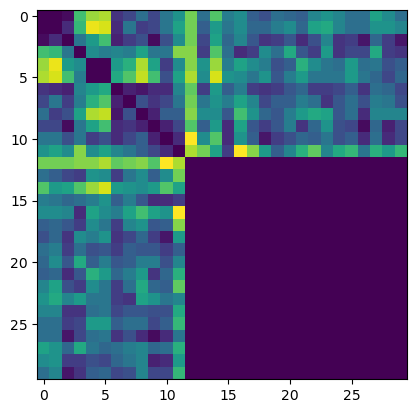

12


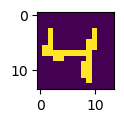

[17.000000207000006, 17.00000020900001]
17.00000020900001
[2.000000219000003, 2.000000220000003]
2.000000220000003
[33.000000209000014, 34.000000209000014]
34.000000209000014
[23.000000209000014, 25.000000208000014]
25.000000208000014
[24.00000021000001, 23.00000021000001]
24.00000021000001
[27.000000205000017, 26.000000208000017]
27.000000205000017
[21.000000206000013, 22.000000207000014]
22.000000207000014
[23.000000209000017, 24.000000209000014]
24.000000209000014
[26.00000020900001, 26.000000210000014]
26.000000210000014
[25.000000207000017, 25.000000207000014]
25.000000207000017
[14.000000212000012, 14.00000021000001]
14.000000212000012
[31.000000212000018, 32.000000209000014]
32.000000209000014
[32.00000021200002, 32.000000211000014]
32.00000021200002
[22.000000218000014, 23.000000215000014]
23.000000215000014
[15.000000216000013, 16.00000021600001]
16.00000021600001
[28.000000210000017, 28.000000209000017]
28.000000210000017
[24.000000206000017, 24.000000207000014]
24.0000002070

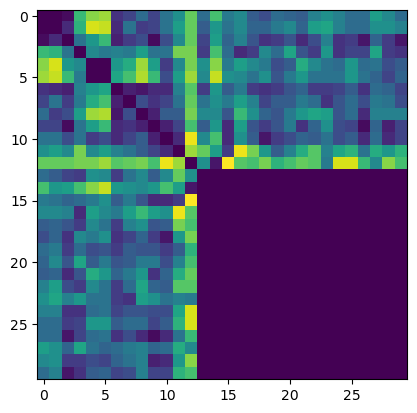

13


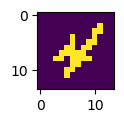

[17.000000212000014, 17.000000213000014]
17.000000213000014
[11.000000217000007, 12.000000216000009]
12.000000216000009
[4.000000211000004, 3.0000002140000026]
4.000000211000004
[4.000000212000003, 3.0000002110000024]
4.000000212000003
[8.00000021000001, 8.00000020900001]
8.00000021000001
[12.000000205000012, 11.000000206000013]
12.000000205000012
[13.000000207000015, 13.000000209000014]
13.000000209000014
[5.000000210000005, 5.000000210000006]
5.000000210000006
[5.000000210000007, 6.000000208000008]
6.000000208000008
[14.00000020800001, 14.00000020800001]
14.00000020800001
[4.000000218000003, 5.000000217000004]
5.000000217000004
[7.000000214000007, 7.000000213000009]
7.000000214000007
[5.000000212000005, 4.000000216000003]
5.000000212000005
[10.000000216000007, 11.00000021200001]
11.00000021200001
[7.000000213000007, 7.000000213000009]
7.000000213000009
[4.000000209000006, 4.000000209000007]
4.000000209000007


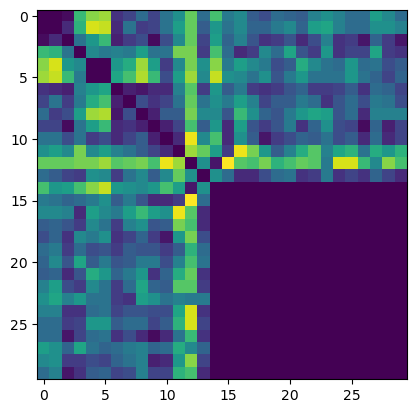

14


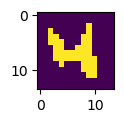

[26.00000021600001, 26.000000216000018]
26.000000216000018
[24.000000211000017, 26.000000211000014]
26.000000211000014
[23.000000216000014, 23.000000218000014]
23.000000218000014
[15.000000216000014, 15.000000216000013]
15.000000216000014
[17.00000021600001, 15.000000217000014]
17.00000021600001
[22.000000216000014, 22.000000215000014]
22.000000216000014
[21.00000021200001, 21.000000214000014]
21.000000214000014
[20.000000213000014, 21.000000211000014]
21.000000211000014
[8.000000219000006, 7.000000218000007]
8.000000219000006
[23.00000021400001, 24.00000021500001]
24.00000021500001
[29.000000217000014, 29.000000217000014]
29.000000217000014
[18.00000021600001, 19.00000021500001]
19.00000021500001
[14.000000212000007, 14.000000211000009]
14.000000212000007
[27.000000210000014, 27.000000211000017]
27.000000211000017
[23.00000020900001, 23.000000211000014]
23.000000211000014


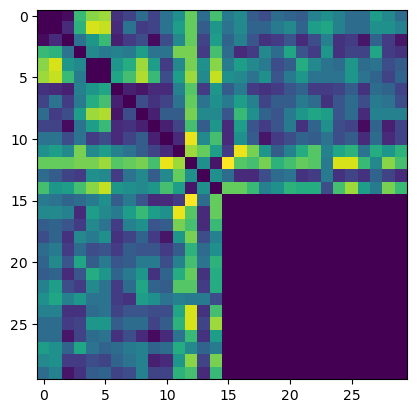

15


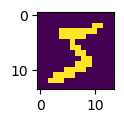

[16.000000217000007, 16.00000021700001]
16.00000021700001
[7.0000002170000055, 7.000000216000006]
7.0000002170000055
[13.00000021500001, 11.00000021800001]
13.00000021500001
[11.00000021300001, 12.00000021200001]
12.00000021200001
[15.000000212000012, 16.00000020900001]
16.00000020900001
[6.000000215000005, 5.000000218000006]
6.000000215000005
[11.000000217000007, 12.00000021500001]
12.00000021500001
[14.000000213000009, 15.00000021000001]
15.00000021000001
[7.000000213000005, 6.000000211000002]
7.000000213000005
[14.00000021200001, 13.00000021600001]
14.00000021200001
[4.000000214000002, 3.000000216000002]
4.000000214000002
[20.00000021000001, 20.000000209000014]
20.00000021000001
[7.000000215000007, 7.000000215000008]
7.000000215000008
[10.000000215000009, 10.000000214000009]
10.000000215000009


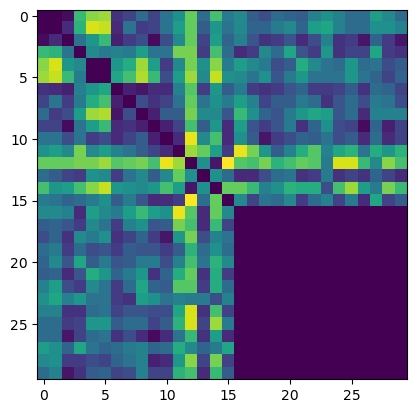

16


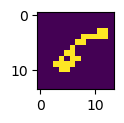

[2.1299999999999996e-07, 2.1299999999999996e-07]
2.1299999999999996e-07
[19.000000211000014, 18.000000211000017]
19.000000211000014
[17.000000207000014, 16.000000207000014]
17.000000207000014
[20.000000204000017, 20.000000204000013]
20.000000204000017
[14.00000021100001, 14.000000214000007]
14.000000214000007
[3.000000209000005, 3.000000212000004]
3.000000212000004
[18.00000020600001, 17.00000021000001]
18.00000020600001
[8.000000212000007, 7.000000215000005]
8.000000212000007
[7.000000218000006, 8.000000217000007]
8.000000217000007
[7.000000217000006, 7.0000002170000055]
7.000000217000006
[16.000000210000007, 15.000000211000007]
16.000000210000007
[11.000000209000007, 11.000000210000007]
11.000000210000007
[10.00000020500001, 10.000000209000008]
10.000000209000008


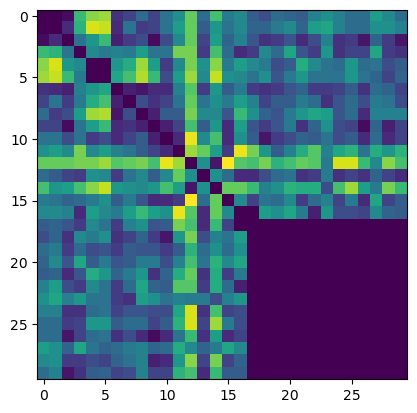

17


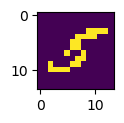

[13.00000021400001, 13.000000213000012]
13.00000021400001
[12.00000020700001, 11.00000020900001]
12.00000020700001
[17.000000207000014, 17.000000206000013]
17.000000207000014
[9.000000211000005, 9.000000210000005]
9.000000211000005
[5.000000206000005, 5.000000207000006]
5.000000207000006
[15.000000209000014, 15.00000021000001]
15.00000021000001
[6.000000214000003, 6.000000214000003]
6.000000214000003
[6.000000217000005, 8.000000214000007]
8.000000214000007
[6.000000213000005, 5.0000002140000035]
6.000000213000005
[15.000000210000008, 15.000000209000008]
15.000000210000008
[8.000000209000005, 8.000000207000005]
8.000000209000005
[6.000000208000004, 7.000000207000006]
7.000000207000006


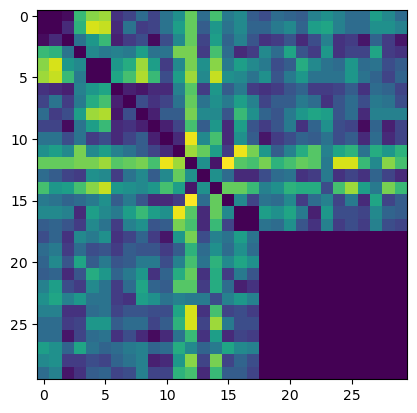

18


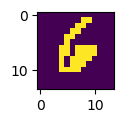

[4.000000210000002, 4.000000211000002]
4.000000211000002
[2.000000214000001, 2.0000002120000016]
2.000000214000001
[9.000000213000009, 9.000000214000009]
9.000000214000009
[8.00000021200001, 8.000000214000009]
8.000000214000009
[8.00000021000001, 9.000000209000014]
9.000000209000014
[10.000000214000012, 11.000000212000009]
11.000000212000009
[11.000000216000007, 10.000000215000012]
11.000000216000007
[9.00000021500001, 9.000000213000009]
9.00000021500001
[10.000000211000007, 10.000000210000007]
10.000000211000007
[9.000000217000007, 10.000000216000009]
10.000000216000009
[4.0000002150000045, 4.000000215000006]
4.000000215000006


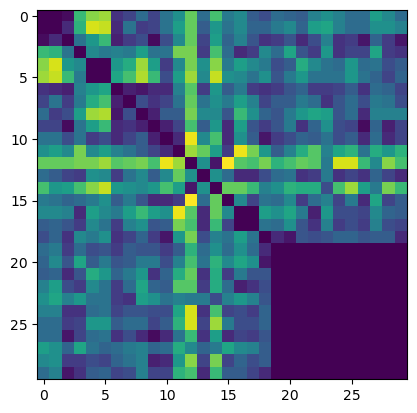

19


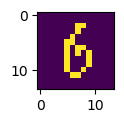

[2.0699999999999993e-07, 2.0699999999999996e-07]
2.0699999999999996e-07
[10.000000212000009, 10.000000212000007]
10.000000212000009
[10.00000020700001, 10.00000020800001]
10.00000020800001
[9.00000021200001, 8.000000210000008]
9.00000021200001
[11.000000211000009, 11.000000212000009]
11.000000212000009
[15.00000021300001, 14.00000021300001]
15.00000021300001
[6.000000214000006, 5.000000216000006]
6.000000214000006
[10.000000208000005, 8.000000209000007]
10.000000208000005
[8.000000207000005, 7.000000208000003]
8.000000207000005
[5.000000208000005, 5.000000209000004]
5.000000209000004


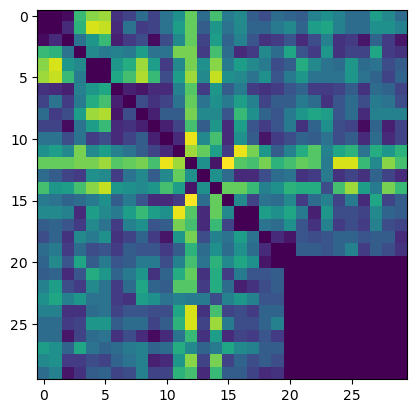

20


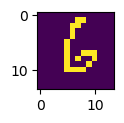

[16.000000208000014, 17.000000210000017]
17.000000210000017
[13.000000209000014, 13.000000207000014]
13.000000209000014
[12.000000208000012, 11.000000208000014]
12.000000208000012
[17.000000213000018, 17.00000021100001]
17.000000213000018
[20.00000021300001, 19.00000021400001]
20.00000021300001
[13.000000214000014, 14.00000021300001]
14.00000021300001
[16.00000020900001, 15.00000020900001]
16.00000020900001
[13.00000020900001, 13.000000210000008]
13.000000210000008
[9.00000020800001, 9.00000020800001]
9.00000020800001


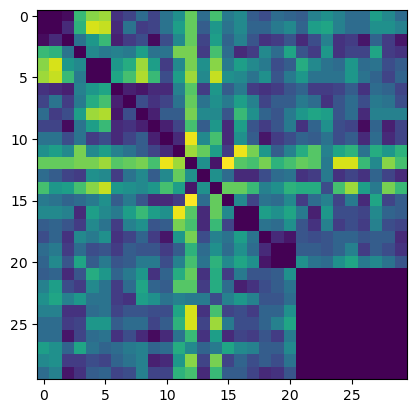

21


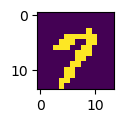

[2.000000211000002, 2.0000002110000015]
2.000000211000002
[16.000000207000006, 16.00000020800001]
16.00000020800001
[2.000000218000002, 2.0000002170000024]
2.000000218000002
[11.00000021200001, 10.000000215000007]
11.00000021200001
[5.000000217000003, 5.000000217000003]
5.000000217000003
[9.000000211000005, 9.000000211000003]
9.000000211000005
[1.0000002090000013, 1.0000002090000013]
1.0000002090000013
[1.0000002120000013, 1.000000212000001]
1.0000002120000013


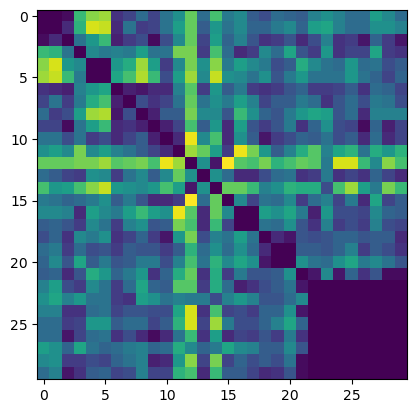

22


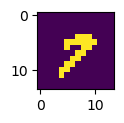

[11.000000210000007, 10.000000212000007]
11.000000210000007
[2.000000213000003, 2.000000212000002]
2.000000213000003
[9.000000218000007, 9.000000216000009]
9.000000218000007
[4.000000212000003, 4.000000212000004]
4.000000212000004
[11.000000211000007, 10.000000208000005]
11.000000211000007
[1.0000002090000006, 1.000000209]
1.0000002090000006
[1.0000002080000012, 1.0000002100000018]
1.0000002100000018


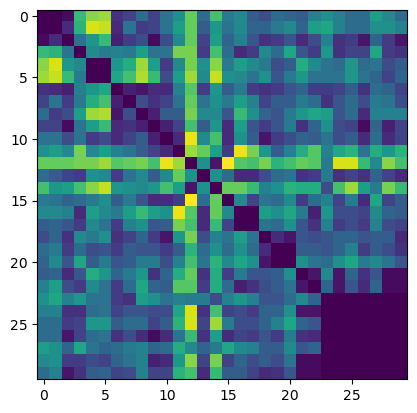

23


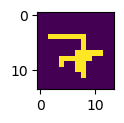

[12.00000021500001, 13.00000021400001]
13.00000021400001
[21.000000214000018, 20.000000215000014]
21.000000214000018
[10.00000021300001, 9.000000214000009]
10.00000021300001
[6.000000215000005, 6.000000215000006]
6.000000215000006
[15.000000207000006, 14.000000210000008]
15.000000207000006
[9.000000212000007, 9.000000209000008]
9.000000212000007


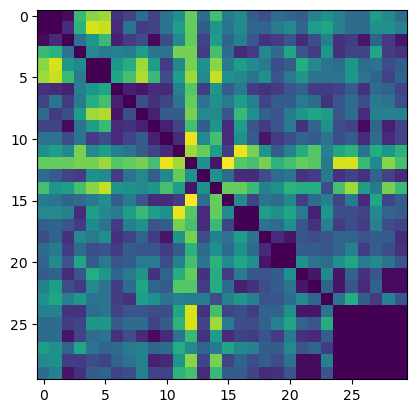

24


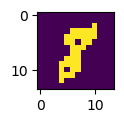

[1.0000002100000014, 1.0000002090000013]
1.0000002100000014
[1.0000002030000004, 1.0000002030000008]
1.0000002030000008
[11.000000212000009, 10.000000211000009]
11.000000212000009
[3.000000211000003, 3.000000211000003]
3.000000211000003
[2.1199999999999994e-07, 2.1299999999999994e-07]
2.1299999999999994e-07


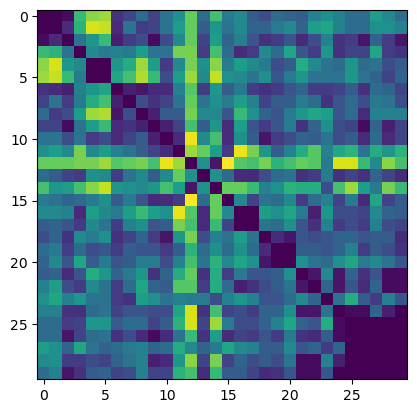

25


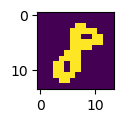

[2.0000002140000017, 2.0000002160000023]
2.0000002160000023
[16.00000021400001, 17.00000021400001]
17.00000021400001
[6.000000212000004, 6.000000212000005]
6.000000212000005
[7.000000212000004, 7.000000211000005]
7.000000212000004


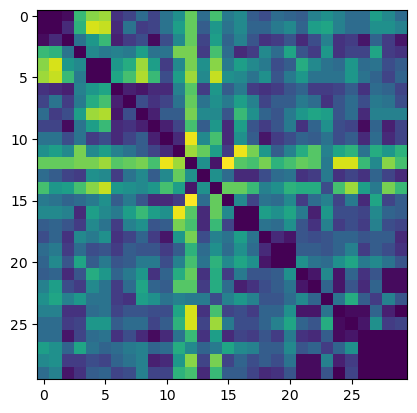

26


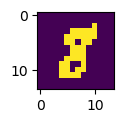

[10.000000210000005, 8.000000211000007]
10.000000210000005
[4.000000212000004, 4.000000212000002]
4.000000212000004
[1.0000002170000009, 2.0000002130000007]
2.0000002130000007


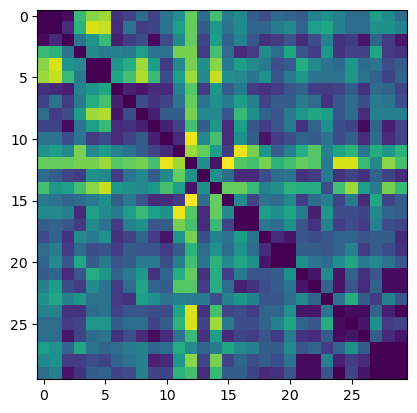

27


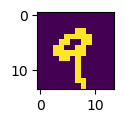

[10.000000205000006, 10.000000205000006]
10.000000205000006
[7.000000206000003, 7.000000208000003]
7.000000208000003


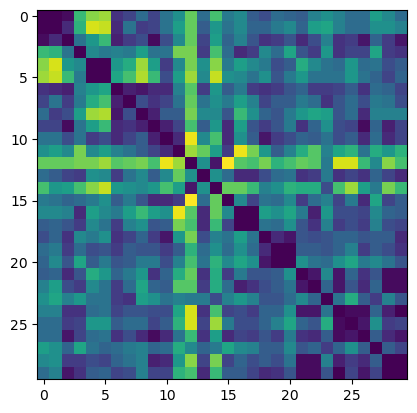

28


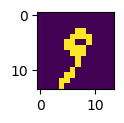

[1.0000002060000013, 1.0000002070000011]
1.0000002070000011


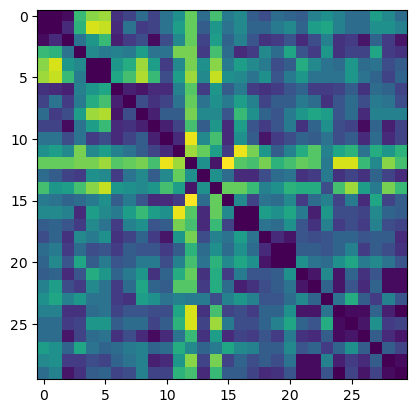

29


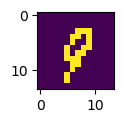

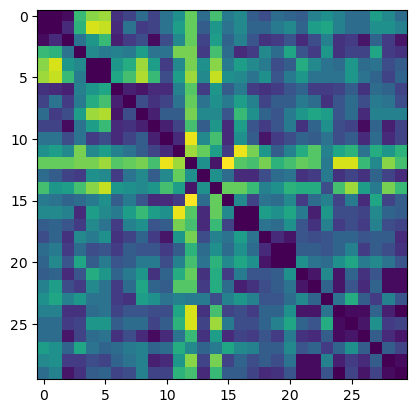

In [12]:
# Updated shift criss-cross constraints with binary images window=1
data_matrix = torch.zeros(batch_size, batch_size)
# plt.imshow(data_matrix)

thresh = torch.Tensor([0.3])  # threshold
for i in range(len(dataset[1])):
    print(i)
    im1 = (dataset[0][i, 0] > thresh).float() * 1
    plt.figure(figsize=[1, 1])
    plt.imshow(im1)
    plt.show()
    
    for j in range(i + 1, len(dataset[1])):
#         print(j)
        im2 = (dataset[0][j, 0] > thresh).float() * 1
        image_diff = get_similarity_score(im1, im2, image_width, image_height, window_size)
        print(image_diff, flush=True)
        data_matrix[i, j] = image_diff
        data_matrix[j, i] = image_diff
        
    plt.imshow(data_matrix)
    plt.show()

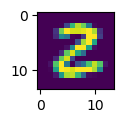

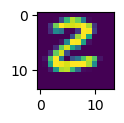

[1.1781394489184026e-06, 1.1791394489184027e-06]


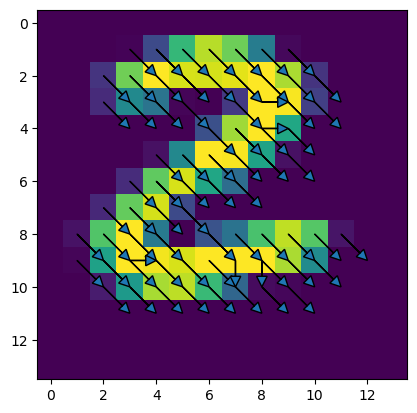

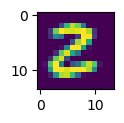

[1.1681394489184027e-06, 1.1681394489184027e-06]


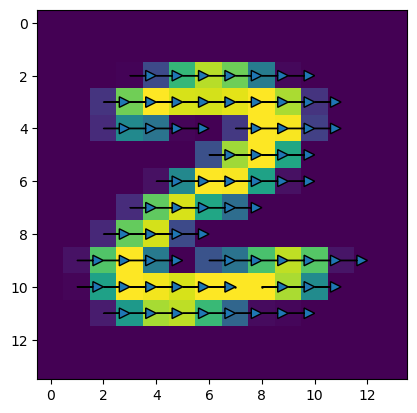

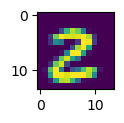

[1.1751394489184026e-06, 1.1751394489184024e-06]


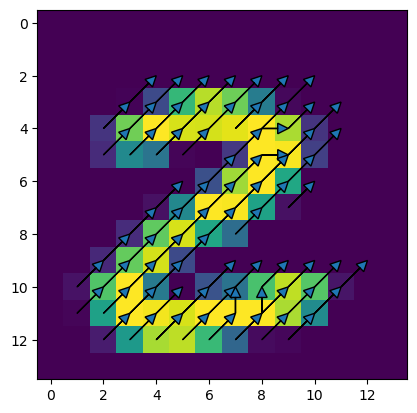

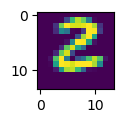

[2.1099999999999994e-07, 2.1099999999999994e-07]


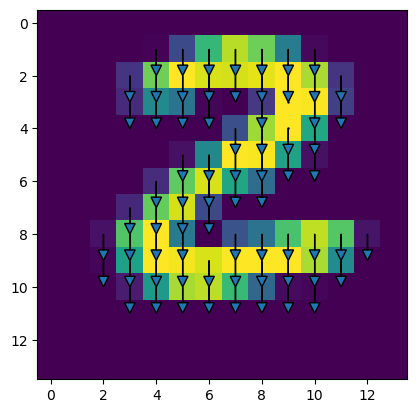

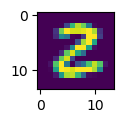

[1.9599999999999998e-07, 1.9599999999999998e-07]


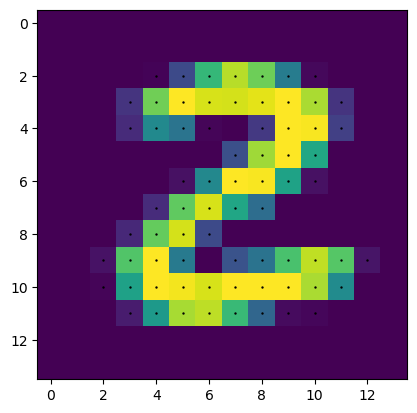

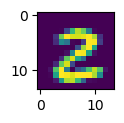

[2.1099999999999992e-07, 2.1099999999999994e-07]


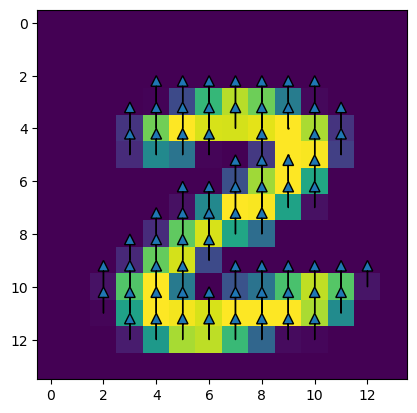

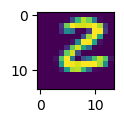

[1.1751394489184028e-06, 1.1761394489184029e-06]


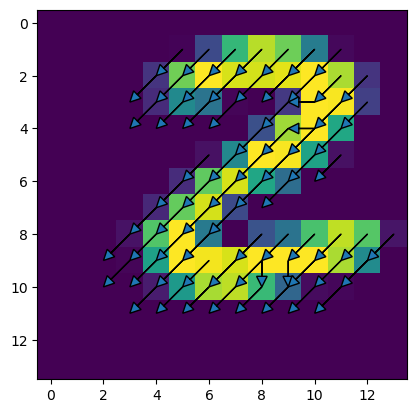

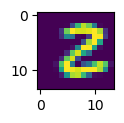

[1.1681394489184025e-06, 1.1681394489184025e-06]


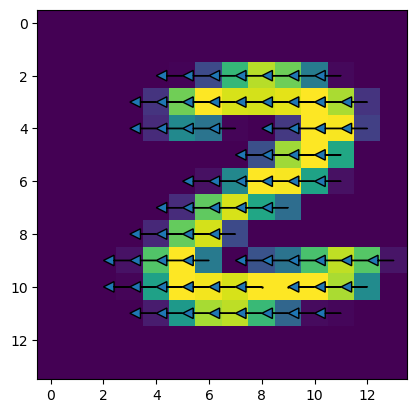

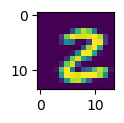

[1.1781394489184028e-06, 1.1791394489184025e-06]


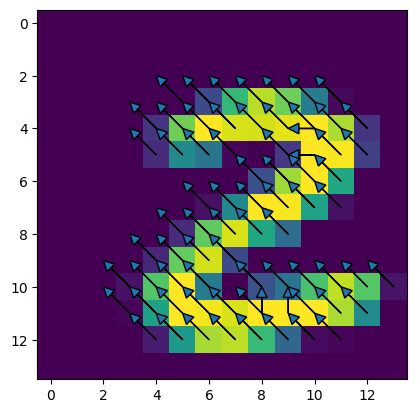

In [11]:
test_img1 = dataset[0][8, 0]
plt.figure(figsize=[1, 1])
plt.imshow(test_img1)
plt.show()

for x in range(3):
    for y in range(3):
        test_img2 = torch.zeros(test_img1.shape)
        test_img2[y:test_img2.shape[0]+y-2, x:test_img2.shape[1]+x-2] = test_img1[1:-1, 1:-1]
        
        plt.figure(figsize=[1, 1])
        plt.imshow(test_img2)
        plt.show()

        image_diff = get_similarity_score(test_img1, test_img2, image_width, image_height, window_size)

        shift_vals = m.getVars()

        plt.imshow(test_img2)
        for val in shift_vals:
            if val.X == 1:
                index = find_between(val.VarName, "[", "]").split(",")
                if len(index) != 4:
                    continue
                if test_img2[int(index[0]), int(index[1])] > 0:
                    if int(index[3])-window_size == 0 and int(index[2])-window_size == 0:
                        plt.scatter(int(index[1]), int(index[0]), c="black", s=0.5)
                    else:
                        plt.arrow(int(index[1]), int(index[0]), int(index[3])-window_size, int(index[2])-window_size, length_includes_head=True, head_width=0.4, head_length=0.4)
        plt.show()

0


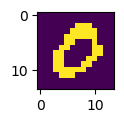

[2.2299999999999995e-07, 2.2099999999999995e-07]
2.2299999999999995e-07
[2.2699999999999995e-07, 2.3099999999999996e-07]
2.3099999999999996e-07
[10.000000229000008, 9.000000226000006]
10.000000229000008
[17.000000231000012, 14.00000023400001]
17.000000231000012
[21.00000023300001, 16.00000022800001]
21.00000023300001
[2.5599999999999996e-07, 2.3299999999999996e-07]
2.5599999999999996e-07
[2.4199999999999997e-07, 2.45e-07]
2.45e-07


In [ ]:
# Updated shift criss-cross constraints with binary images window=2
data_matrix = torch.zeros(batch_size, batch_size)
# plt.imshow(data_matrix)

thresh = torch.Tensor([0.3])  # threshold
for i in range(len(dataset[1])):
    print(i)
    im1 = (dataset[0][i, 0] > thresh).float() * 1
    plt.figure(figsize=[1, 1])
    plt.imshow(im1)
    plt.show()
    
    for j in range(i + 1, len(dataset[1])):
#         print(j)
        im2 = (dataset[0][j, 0] > thresh).float() * 1
        image_diff = get_similarity_score(im1, im2, image_width, image_height, window_size)
        print(image_diff, flush=True)
        data_matrix[i, j] = image_diff
        data_matrix[j, i] = image_diff
        
    plt.imshow(data_matrix)
    plt.show()